In [1]:
# To run on CPU

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
import pandas as pd
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
import random
import numpy as np


import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import nltk
# nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import re


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import pickle
from tqdm import tqdm  # For showing progress bar (optional)
import math

2025-05-18 15:11:57.397012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 15:11:57.409537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747563117.424758   67779 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747563117.429434   67779 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747563117.441178   67779 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:

caption_file = '/home/murtaza/University_Data/deep_learning/assignment3/Task_01_dataset_flicker/captions.txt' 
df = pd.read_csv(caption_file)

# Group and convert to a dictionary directly using pandas
image_to_captions = df.groupby('image')['caption'].apply(list).to_dict()
random.seed(42)

# Get all unique image filenames
all_images = list(image_to_captions.keys())
random.shuffle(all_images)

# Define split sizes
num_train = 1100
num_val = 250
num_test = 250

# Split the image filenames
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train + num_val]
test_images = all_images[num_train + num_val:num_train + num_val + num_test]

# Create separate dicts for each split
train_data = {img: image_to_captions[img] for img in train_images}
val_data = {img: image_to_captions[img] for img in val_images}
test_data = {img: image_to_captions[img] for img in test_images}

In [5]:
list(test_data.items())[0]


('3425846980_912943b4f9.jpg',
 ['A guy playing tennis , two nearby spectators , and a crowd watching .',
  'A tennis player hitting a ball .',
  'The tennis player gets ready to hit the ball that is almost at him .',
  'The tennis player is hitting the ball with his racquet , while others watch the match .',
  'the tennis player wearing white hits the tennis ball .'])

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, image_dir ,data_dict, tokenizer, max_length):
        self.image_dir = image_dir
        self.data = list(data_dict.items())  # [(img_name, [captions])]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, captions = self.data[idx]
        caption = random.choice(captions)  # randomly pick one caption
        caption = text_preprocessing(caption)

        caption_seq = self.tokenizer.texts_to_sequences([caption])[0]
        caption_seq = pad_sequences([caption_seq], maxlen=self.max_length, padding='post')[0]
        caption_tensor = tf.convert_to_tensor(caption_seq, dtype=tf.int32)

        image_path = os.path.join(self.image_dir, img_name)

        image_tensor = image_preprocessing(image_path)

        return image_tensor, caption_tensor

def image_preprocessing(image_path):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0  # Scale to [0, 1]

    # Normalize using ImageNet mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std
    return tf.convert_to_tensor(img, dtype=tf.float32)

def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces - as asked a mandatory extra preporcessing step
    text = f"startsentence {text} endsentence"
    return text


In [7]:
print(text_preprocessing( "A caption: with     punctuation! & symbols."))

startsentence a caption with punctuation symbols endsentence


In [8]:
train_data.values()

dict_values([['A black and white dog is playing with a sheep in a field .', 'A dog and sheep run together .', 'A dog herds a sheep .', 'a sheep chases a dog .', 'The black and white dog is herding the sheep .'], ['A girl sits and laughs while in a kiddie pool .', 'A little girl in a metal tub filled with water .', 'A little girl is sitting in a metal tub filled with water .', 'A small girl in a tub of water .', 'A smiling young girl wearing a swimsuit is soaking in a tub of water .'], ['A skier coming over a snowy hill while people look on .', 'A snowboarder takes a ramp made of snow while others watch .', 'One person snowboarding while others look on .', 'People are watching a skier perform a trick in the air .', 'There are several people watching a person in the air with skies surrounded by mountains and snow .'], ['A black dog paddles behind a black cat in a body of water .', 'A dog and a cat are swimming in a swimming pool .', 'Two black dogs are dog paddling in a sparkling blue po

In [9]:
# Flatten all captions from train_data
train_captions = []
for caption_list in train_data.values():
    for caption in caption_list:
        train_captions.append(text_preprocessing(caption))


In [10]:
#Vocabulary creation
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_captions)

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0)
print("Vocabulary Size:", vocab_size)


# Tokenize the captions
train_sequences = tokenizer.texts_to_sequences(train_captions)

# Find the maximum caption length
max_caption_length = max(len(seq) for seq in train_sequences)
print("Max caption length:", max_caption_length)


Vocabulary Size: 3484
Max caption length: 35


In [11]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [12]:
#checking the tokenizer
print(train_captions[1])
seq = tokenizer.texts_to_sequences([train_captions[1]])[0]
print(seq)
print(tokenizer.sequences_to_texts([seq]))


startsentence a dog and sheep run together endsentence
[3, 2, 10, 9, 467, 172, 187, 4]
['startsentence a dog and sheep run together endsentence']


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# --- Image Feature Extractor (ResNet50) ---
def create_image_embedding_model():
    # Input for image
    image_input = Input(shape=(224, 224, 3))  # ResNet50 expects (224, 224, 3)
    
    # Use the ResNet50 pre-trained model (without the top classification layer)
    base_model = ResNet50(weights='imagenet', include_top=False)(image_input)
    
    # Apply GlobalAveragePooling to the output of the last convolutional layer
    x = GlobalAveragePooling2D()(base_model)
    
    # Add a Dense layer to project the features to a fixed-size embedding space
    x = Dense(256, activation='relu')(x)
    
    # Add a dropout layer for regularization
    x = Dropout(0.5)(x)  # Adjust dropout rate as needed
    
    # Create a final image feature model
    image_embedding_model = Model(inputs=image_input, outputs=x)
    
    return image_embedding_model


In [14]:
image_embedding_model = create_image_embedding_model()
image_embedding_model.summary()

2025-05-05 22:03:26.283976: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-05 22:03:26.284001: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-05-05 22:03:26.284006: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-05-05 22:03:26.284008: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-05 22:03:26.284011: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: Hack-Book
2025-05-05 22:03:26.284013: I external/local_xla/xla/stream_executor/cuda/cud

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,256 (91.98 MB)

 Trainable params: 24,059,136 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model

# --- Text Embedding Model ---
def create_text_embedding_model(vocab_size, max_caption_length, embedding_dim=256):
    # Input for captions (sequence of word indices)
    caption_input = Input(shape=(max_caption_length,))
    
    # Embedding layer to convert word indices into dense vectors
    caption_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(caption_input)
    
    # LSTM layer to process the sequence of embeddings
    caption_lstm = LSTM(256, return_sequences=False)(caption_embedding)
    
    # Dense layer to output a fixed-size vector (optional)
    caption_output = Dense(256, activation='relu')(caption_lstm)
    
    # Create the text embedding model
    text_embedding_model = Model(inputs=caption_input, outputs=caption_output)
    
    return text_embedding_model


In [16]:
text_embedding_model = create_text_embedding_model(vocab_size, max_caption_length)
text_embedding_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │    891,904 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,483,008 (5.66 MB)

 Trainable params: 1,483,008 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.layers import Concatenate, RepeatVector, LSTM, TimeDistributed, Dense, Input
from tensorflow.keras.models import Model

def create_captioning_model(vocab_size, max_caption_length, embedding_dim=256):
    # Image and Text Embedding Models
    image_embedding_model = create_image_embedding_model()
    text_embedding_model = create_text_embedding_model(vocab_size, max_caption_length, embedding_dim)

    # Inputs
    image_input = image_embedding_model.input
    caption_input = text_embedding_model.input

    # Outputs (both are (None, 256))
    image_features = image_embedding_model.output
    text_features = text_embedding_model.output

    # Merge embeddings
    merged_features = Concatenate(axis=-1)([image_features, text_features])  # (None, 512)

    # Repeat vector to match caption length
    repeated = RepeatVector(max_caption_length)(merged_features)  # (None, max_caption_length, 512)

    # LSTM Decoder
    x = LSTM(512, return_sequences=True)(repeated)
    x = LSTM(512, return_sequences=True)(x)
    x = TimeDistributed(Dense(512, activation='relu'))(x)
    output = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)

    # Final Model
    model = Model(inputs=[image_input, caption_input], outputs=output)
    return model



In [18]:
captioning_model = create_captioning_model(vocab_size, max_caption_length)
captioning_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │    891,904 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 35)        │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 35, 512)   │          0 │ concatenate[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 35, 512)   │  2,099,200 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 35, 512)   │  2,099,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 35, 512)   │    262,656 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 35, 3484)  │  1,787,292 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,843,612 (121.47 MB)

 Trainable params: 31,790,492 (121.27 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:

# --- Data Preparation ---
image_dir = '/home/murtaza/University_Data/deep_learning/assignment3/Task_01_dataset_flicker/Images'
train_dataset = FlickrDataset(image_dir, train_data, tokenizer, max_length=max_caption_length)
val_dataset = FlickrDataset(image_dir, val_data, tokenizer,  max_length=max_caption_length)
test_dataset = FlickrDataset(image_dir, test_data, tokenizer, max_length=max_caption_length)


In [20]:
def dataset_generator(dataset):
    for i in range(len(dataset)):
        image, caption = dataset[i]
        input_caption = caption[:-1]
        target_caption = caption[1:]
            # Pad input_caption to length 35
        input_caption = tf.pad(input_caption, [[0, 1]], constant_values=0)  # Padding to length 35

        # Pad target_caption to length 35
        target_caption = tf.pad(target_caption, [[0, 1]], constant_values=0)  # Padding to length 35

        yield ((image, input_caption), target_caption)
output_signature = (
    (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),           # image
        tf.TensorSpec(shape=(max_caption_length,), dtype=tf.int32) # input caption
    ),
    tf.TensorSpec(shape=(max_caption_length,), dtype=tf.int32)     # target caption
)



In [21]:

BATCH_SIZE = 32
# Create TensorFlow datasets from your FlickrDataset instance
train_tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_dataset),  # assuming train_dataset is an instance of FlickrDataset
    output_signature=output_signature
).shuffle(1000).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(val_dataset),  # assuming val_dataset is an instance of FlickrDataset
    output_signature=output_signature
).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)



In [22]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np


class BLEUCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data, tokenizer, max_len):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.train_bleus = []
        self.val_bleus = []

    def set_model(self, model):
        self.model_ref = model  # This is how Keras passes the model reference

    def on_epoch_end(self, epoch, logs=None):
        train_bleu = self._compute_bleu(self.train_data)
        val_bleu = self._compute_bleu(self.val_data)

        self.train_bleus.append(train_bleu)
        self.val_bleus.append(val_bleu)

        print(f"\nEpoch {epoch+1} - Train BLEU: {train_bleu:.4f} | Val BLEU: {val_bleu:.4f}")

    def _compute_bleu(self, dataset):

        bleu_scores = []
        smooth_fn = SmoothingFunction().method1

        for (img_batch, input_caption), target_caption in dataset.take(5):  # Use a few batches to save time
            preds = self.model_ref.predict_on_batch([img_batch, input_caption])
            predicted_ids = tf.argmax(preds, axis=-1).numpy()

            for pred, target in zip(predicted_ids, target_caption.numpy()):
                pred_caption = self._decode(pred)
                target_caption_text = self._decode(target)

                ref = [target_caption_text.split()]
                hyp = pred_caption.split()
                bleu = sentence_bleu(ref, hyp, smoothing_function=smooth_fn, weights=(0.5, 0.5))
                bleu_scores.append(bleu)

        return np.mean(bleu_scores)

    def _decode(self, seq):
        words = []
        for idx in seq:
            if idx == 0:
                continue
            word = self.tokenizer.index_word.get(idx, "")
            if word == '<end>':
                break
            words.append(word)
        return ' '.join(words)

    def on_train_end(self, logs=None):
        import matplotlib.pyplot as plt
        plt.plot(self.train_bleus, label="Train BLEU")
        plt.plot(self.val_bleus, label="Val BLEU")
        plt.xlabel("Epochs")
        plt.ylabel("BLEU Score")
        plt.title("BLEU Score over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()


In [23]:
#callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# to decay and reduce LR
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # Reduce LR by 50%
    patience=2,             # Wait 2 epochs with no improvement
    min_lr=1e-6,            # Don't go below this
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,            # Stop if no improvement after 5 epochs
    restore_best_weights=True,
    verbose=1
)



Epoch 1/10


2025-05-05 22:07:05.217462: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.2709

2025-05-05 22:08:43.448840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 865 of 1000
2025-05-05 22:08:44.263638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-05-05 22:08:56.380536: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 1 - Train BLEU: 0.0000 | Val BLEU: 0.0000

Epoch 1: val_loss improved from inf to 2.49633, saving model to best_model.weights.h5


2025-05-05 22:08:59.972839: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 4.2393 - val_loss: 2.4963 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.2474

2025-05-05 22:10:31.505768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 943 of 1000
2025-05-05 22:10:31.936920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 2 - Train BLEU: 0.0003 | Val BLEU: 0.0001

Epoch 2: val_loss improved from 2.49633 to 2.11005, saving model to best_model.weights.h5


2025-05-05 22:10:42.699958: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - loss: 2.2441 - val_loss: 2.1100 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8100

2025-05-05 22:12:12.177118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 974 of 1000
2025-05-05 22:12:12.394008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 3 - Train BLEU: 0.0403 | Val BLEU: 0.0401

Epoch 3: val_loss improved from 2.11005 to 2.01007, saving model to best_model.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - loss: 1.8090 - val_loss: 2.0101 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6849

2025-05-05 22:13:53.283686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 990 of 1000
2025-05-05 22:13:53.359494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 4 - Train BLEU: 0.0267 | Val BLEU: 0.0249

Epoch 4: val_loss did not improve from 2.01007
35/35 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 1.6856 - val_loss: 2.0314 - learning_rate: 0.0010
Epoch 5/10


2025-05-05 22:14:05.034928: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6687
Epoch 5 - Train BLEU: 0.0771 | Val BLEU: 0.0807

Epoch 5: val_loss improved from 2.01007 to 1.85778, saving model to best_model.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - loss: 1.6687 - val_loss: 1.8578 - learning_rate: 0.0010
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6252

2025-05-05 22:17:15.142752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 998 of 1000
2025-05-05 22:17:15.155907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 6 - Train BLEU: 0.0903 | Val BLEU: 0.0841

Epoch 6: val_loss improved from 1.85778 to 1.64164, saving model to best_model.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 1.6264 - val_loss: 1.6416 - learning_rate: 0.0010
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6220
Epoch 7 - Train BLEU: 0.1034 | Val BLEU: 0.0829

Epoch 7: val_loss did not improve from 1.64164
35/35 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 1.6222 - val_loss: 1.6878 - learning_rate: 0.0010
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6168

2025-05-05 22:20:37.365850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 992 of 1000
2025-05-05 22:20:37.430150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 8 - Train BLEU: 0.0946 | Val BLEU: 0.0894

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 1.64164
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - loss: 1.6167 - val_loss: 1.6487 - learning_rate: 0.0010
Epoch 9/10


2025-05-05 22:20:49.474246: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5659

2025-05-05 22:22:20.952641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 969 of 1000
2025-05-05 22:22:21.233250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 9 - Train BLEU: 0.0994 | Val BLEU: 0.0980

Epoch 9: val_loss did not improve from 1.64164
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 1.5658 - val_loss: 1.6779 - learning_rate: 5.0000e-04
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5441

2025-05-05 22:24:03.653566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 888 of 1000
2025-05-05 22:24:04.731274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 10 - Train BLEU: 0.0774 | Val BLEU: 0.0850

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: val_loss did not improve from 1.64164
35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - loss: 1.5441 - val_loss: 1.6619 - learning_rate: 5.0000e-04


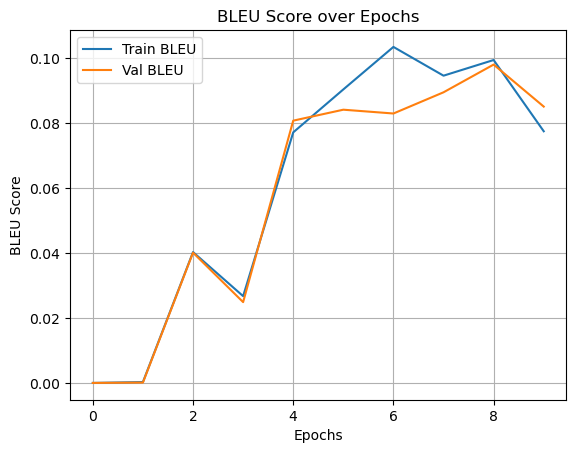

Restoring model weights from the end of the best epoch: 6.


In [25]:
epochs = 10
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
captioning_model.compile(optimizer=optimizer, loss=loss_fn)

train_steps = math.ceil(len(train_dataset) / BATCH_SIZE)
val_steps = math.ceil(len(val_dataset) / BATCH_SIZE)

bleu_callback = BLEUCallback(train_tf_dataset, val_tf_dataset, tokenizer, max_caption_length)

# Train the model
history = captioning_model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[bleu_callback, lr_reducer, checkpoint, early_stopping] 

)


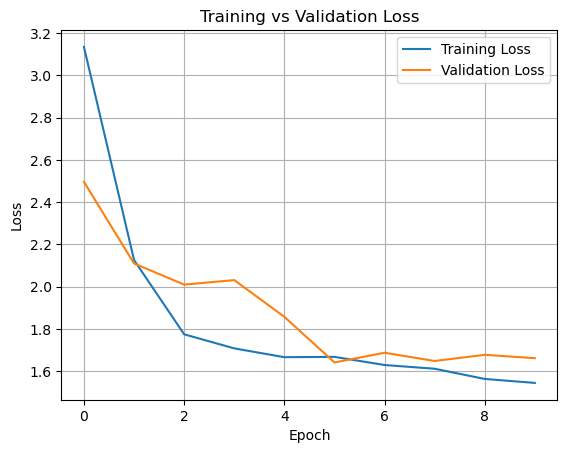

In [26]:

# Plot training & validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [210]:
# Load the trained weights
captioning_model.load_weights('best_model.weights.h5')

with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


In [29]:
def generate_caption(model, image_tensor, tokenizer, max_length):
    input_caption = [tokenizer.word_index['startsentence']]
    
    for _ in range(max_length):
        input_seq = tf.keras.preprocessing.sequence.pad_sequences(
            [input_caption], maxlen=max_length, padding='post'
        )
        
        predictions = model.predict(
            [tf.expand_dims(image_tensor, 0), input_seq], verbose=0
        )
        
        # Visualize the full prediction distribution
        # print(f"Predictions at step {_}: {predictions[0, len(input_caption)-1]}")
        # Sort predictions by probability to check the top tokens
        # sorted_indices = np.argsort(predictions[0, len(input_caption)-1])[::-1]
        # print("Top 5 tokens (sorted by probability):")
        # for idx in sorted_indices[:5]:
        #     print(f"Token: {tokenizer.index_word.get(idx, '<unk>')}, Probability: {predictions[0, len(input_caption)-1][idx]}")
        # Sampling from the probability distribution (instead of using argmax)
        probabilities = tf.nn.softmax(predictions[0, len(input_caption)-1]).numpy()
        # predicted_id = np.random.choice(len(probabilities), p=probabilities)

        predicted_id = tf.argmax(predictions[0, len(input_caption)-1]).numpy()

        word = tokenizer.index_word.get(predicted_id, '<unk>')
        
        next_token = tf.argmax(predictions[0, len(input_caption)-1]).numpy()
        # print("Next token index:", next_token, "Word:", tokenizer.index_word.get(next_token, "<UNK>"))

        if word == 'endsentence':
            break
        input_caption.append(predicted_id)
    
    caption = [tokenizer.index_word.get(i, '') for i in input_caption[1:]]
    return ' '.join(caption)


In [30]:
# Example: show 5 generated captions from test set
for i in range(5):
    image_tensor, _ = test_dataset[i]  # caption is unused
    # image_tensor = tf.keras.applications.resnet50.preprocess_input(image_tensor)

    caption = generate_caption(captioning_model, image_tensor, tokenizer, max_length=max_caption_length)
    print(f"Generated Caption {i+1}: {caption}")


Generated Caption 1: a a in
Generated Caption 2: a a in
Generated Caption 3: a a in
Generated Caption 4: a a in
Generated Caption 5: a a in


Generated Caption: a a in


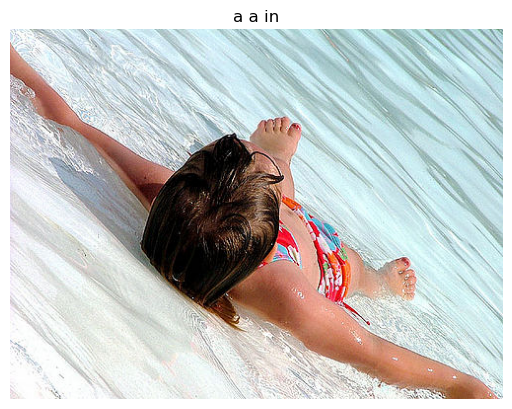

In [35]:
# Test_eval

eval_image_path = "/home/murtaza/University_Data/deep_learning/assignment3/Task_01_dataset_flicker/Images/667626_18933d713e.jpg"
eval_image_tensor = image_preprocessing(eval_image_path)

# Load the trained weights
captioning_model.load_weights('best_model.weights.h5')

with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
# Generate caption
caption = generate_caption(captioning_model, eval_image_tensor, tokenizer, max_length=max_caption_length)
print(f"Generated Caption: {caption}")
# Visualize the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(eval_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()
